## Step 1: Imports & Global Configuration

In [1]:
import sys
import types
import pandas as pd 

# ---- Full backward compatibility shim for old Pandas pickles ----
numeric_module = types.ModuleType("pandas.core.indexes.numeric")

# CORRECTED: Inherit from pd.Index, do NOT use (self)
class Int64Index(pd.Index): 
    pass

numeric_module.Int64Index = Int64Index
sys.modules["pandas.core.indexes.numeric"] = numeric_module

In [2]:
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter
from itertools import combinations

plt.style.use("seaborn-v0_8")
sns.set_context("talk")

## Step 2: Dataset Path Configuration

In [3]:
TRAIN_DIR = "../data/processed/train/preprocessed/250Hz/60s"

## Step 3: Load .pk files

In [4]:
def load_pk_file(path):
    with open(path, "rb") as f:
        data = pickle.load(f)
    return data


pk_files = sorted([
    os.path.join(TRAIN_DIR, f)
    for f in os.listdir(TRAIN_DIR)
    if f.endswith(".pk")
])

print(f"Number of training ECG samples: {len(pk_files)}")

Number of training ECG samples: 5501


## Step 4: Inspect One Sample

In [6]:
sample = load_pk_file(pk_files[0])

# CORRECTED: Unpack the tuple first
signal_data, label_data = sample

print(f"Signal Type: {type(signal_data)}")
print(f"Signal Shape: {signal_data.shape}")
print(f"Label Keys: {label_data.keys()}")

Signal Type: <class 'pandas.core.frame.DataFrame'>
Signal Shape: (15000, 12)
Label Keys: dict_keys(['age', 'sex', 'dx', 'rx', 'hx', 'sx', 'classes_one_hot', 'classes_encoded'])


In [7]:
# 1. Inspect the tuple structure first
print(f"Type of data: {type(sample)}")
print(f"Length of tuple: {len(sample)}")

# 2. Check the types of the elements inside
for i, item in enumerate(sample):
    print(f"Item {i} type: {type(item)}")
    if hasattr(item, 'shape'):
        print(f"Item {i} shape: {item.shape}")
    else:
        print(f"Item {i} content: {item}")

# 3. Likely Unpacking Scenario (Standard for ML datasets)
# If length is 2, it's usually (Input, Target)
if len(sample) == 2:
    X_signal, y_label = sample
    print("\n--- Unpacked Data ---")
    print(f"ECG Signal Shape: {X_signal.shape}")
    print(f"Labels: {y_label}")

Type of data: <class 'tuple'>
Length of tuple: 2
Item 0 type: <class 'pandas.core.frame.DataFrame'>
Item 0 shape: (15000, 12)
Item 1 type: <class 'dict'>
Item 1 content: {'age': '74', 'sex': 'Male', 'dx': '59118001', 'rx': 'Unknown', 'hx': 'Unknown', 'sx': 'Unknown', 'classes_one_hot': 0    0
1    0
2    0
3    0
4    1
5    0
6    0
7    0
8    0
Name: data/CinC_CPSC/train/preprocessed/4ms/A0001.pk, dtype: int64, 'classes_encoded': [4]}

--- Unpacked Data ---
ECG Signal Shape: (15000, 12)
Labels: {'age': '74', 'sex': 'Male', 'dx': '59118001', 'rx': 'Unknown', 'hx': 'Unknown', 'sx': 'Unknown', 'classes_one_hot': 0    0
1    0
2    0
3    0
4    1
5    0
6    0
7    0
8    0
Name: data/CinC_CPSC/train/preprocessed/4ms/A0001.pk, dtype: int64, 'classes_encoded': [4]}


## Step 5: Extract Signals & Labels

In [8]:
X = []
y = []

print("Loading data...")

for i, file in enumerate(pk_files):
    # Load tuple
    data_tuple = load_pk_file(file)
    
    # 1. Extract Signal (Item 0)
    # Original shape is (15000, 12) -> Transpose to (12, 15000) for (Leads, Time)
    sig = data_tuple[0].values.T 
    X.append(sig)
    
    # 2. Extract Label (Item 1)
    # The dictionary key is 'classes_one_hot' (found in your previous error logs)
    # We must ensure it's a list or array, not a pandas Series with index
    lbl = data_tuple[1]['classes_one_hot'].values 
    y.append(lbl)

    if i % 1000 == 0:
        print(f"Loaded {i} files...")

# Stack into big arrays
X = np.stack(X)   # Shape: (N, 12, 15000)
y = np.stack(y)   # Shape: (N, 9)

print("Final Signals shape:", X.shape)
print("Final Labels shape :", y.shape)

Loading data...
Loaded 0 files...
Loaded 1000 files...
Loaded 2000 files...
Loaded 3000 files...
Loaded 4000 files...
Loaded 5000 files...
Final Signals shape: (5501, 12, 15000)
Final Labels shape : (5501, 9)


## Step 6: Signal Integrity Checks (MANDATORY)

In [9]:
assert not np.isnan(X).any(), "NaNs detected in ECG signals"
assert not np.isinf(X).any(), "Infinite values detected"

print("ECG signal integrity verified.")

ECG signal integrity verified.


## Step 7: Duration & Sampling Confirmation

In [11]:
# The dataset documentation confirms preprocessed data is 250Hz
fs = 250 

# X.shape is (N, 12, 15000), so the last dimension is the time steps
signal_length = X.shape[-1] 

print(f"Sampling Rate: {fs} Hz")
print(f"Signal Duration: {signal_length / fs:.1f} seconds")

Sampling Rate: 250 Hz
Signal Duration: 60.0 seconds


## Step 8: Comprehensive Signal Visualization across all 12 leads

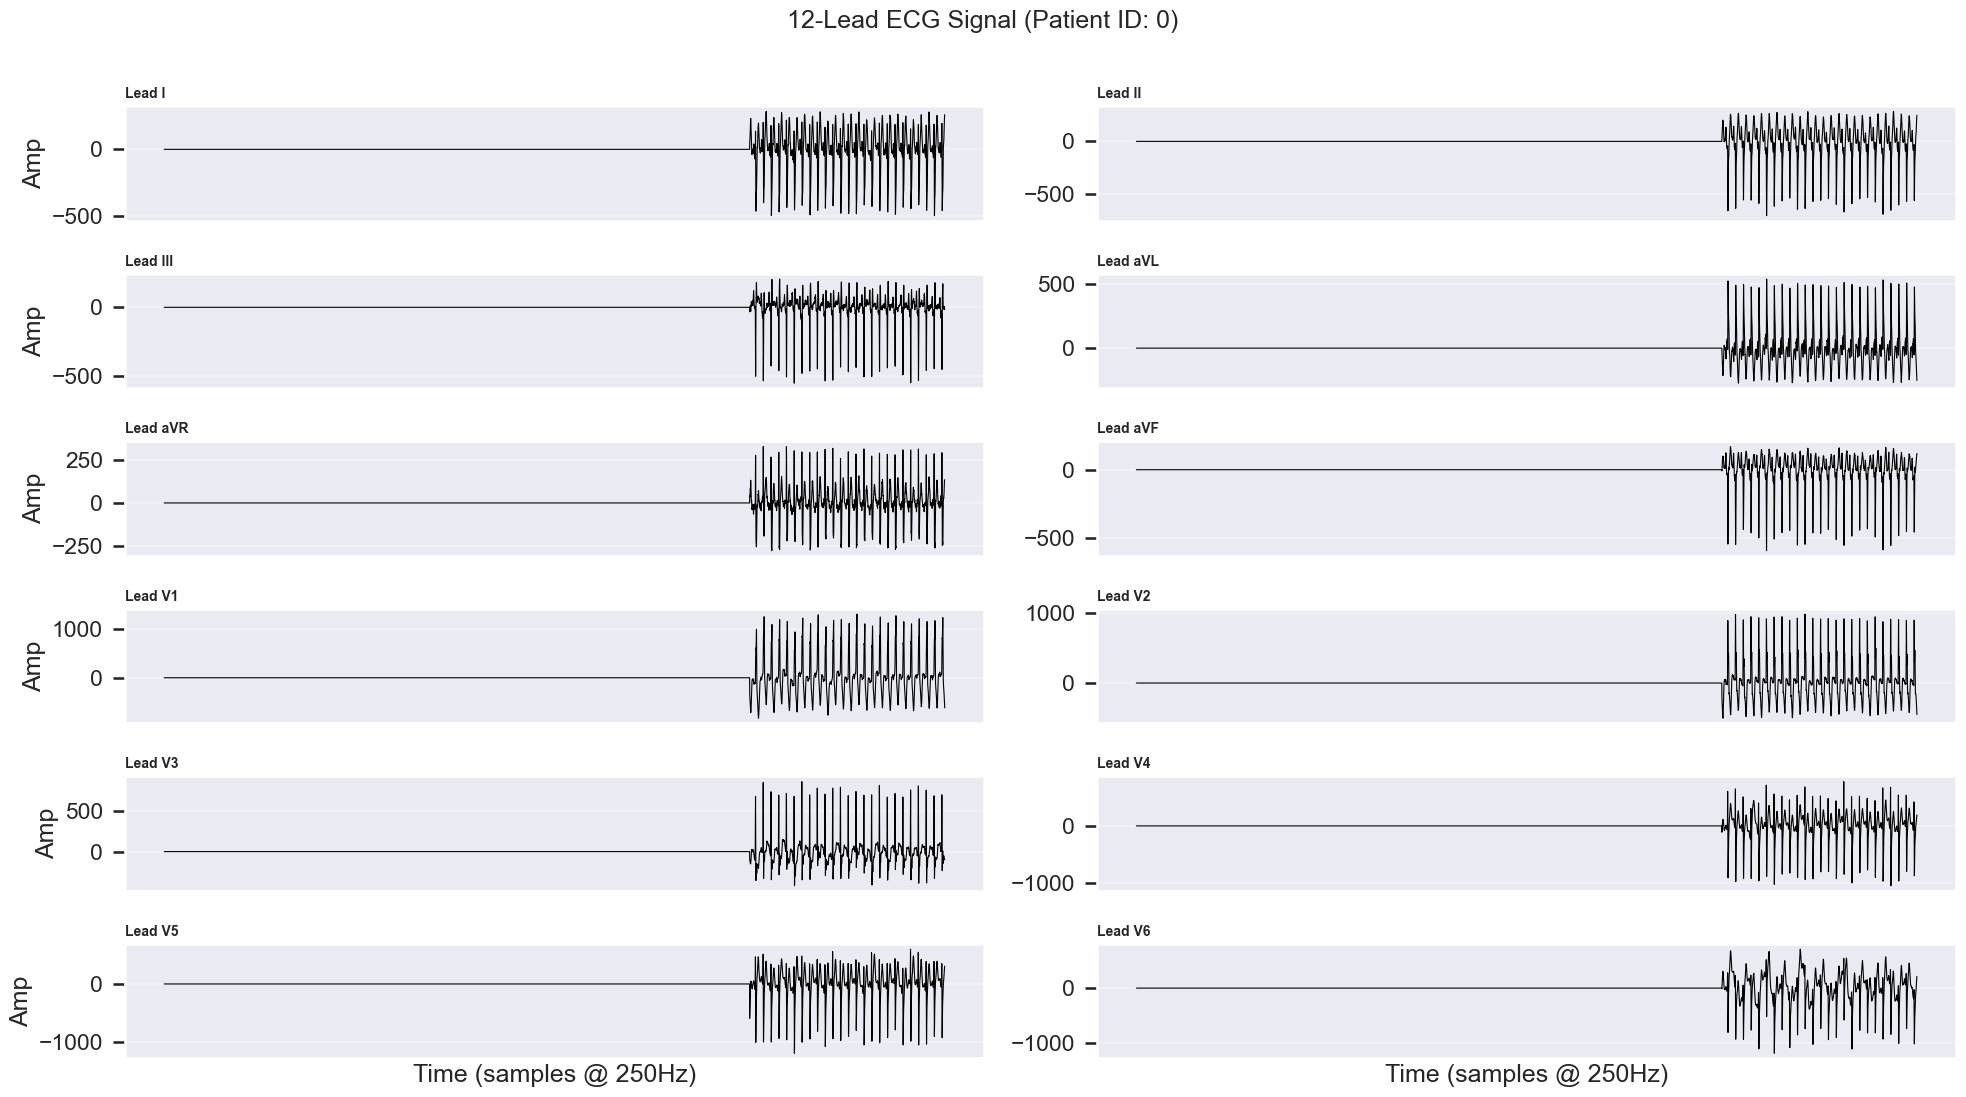

In [20]:
# Select a sample (Change idx to see different patients)
idx = 0 
signal = X[idx] 
lead_names = ["I", "II", "III", "aVL", "aVR", "aVF", "V1", "V2", "V3", "V4", "V5", "V6"]

plt.figure(figsize=(20, 12))
for i in range(12):
    plt.subplot(6, 2, i + 1)
    plt.plot(signal[i, :], linewidth=0.8, color='black')
    plt.title(f"Lead {lead_names[i]}", fontsize=10, fontweight="bold", loc='left')
    plt.grid(True, alpha=0.3)
    plt.xticks([]) # Hide x-axis for cleanliness until the bottom
    
    # Add y-label only on left column
    if i % 2 == 0: plt.ylabel("Amp")
    
    # Add x-label only on bottom row
    if i >= 10: plt.xlabel("Time (samples @ 250Hz)")

plt.suptitle(f"12-Lead ECG Signal (Patient ID: {idx})", fontsize=18, y=0.95)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## Step 9: Class Distribution & Imbalance Assessment (9 Arrhythmias)

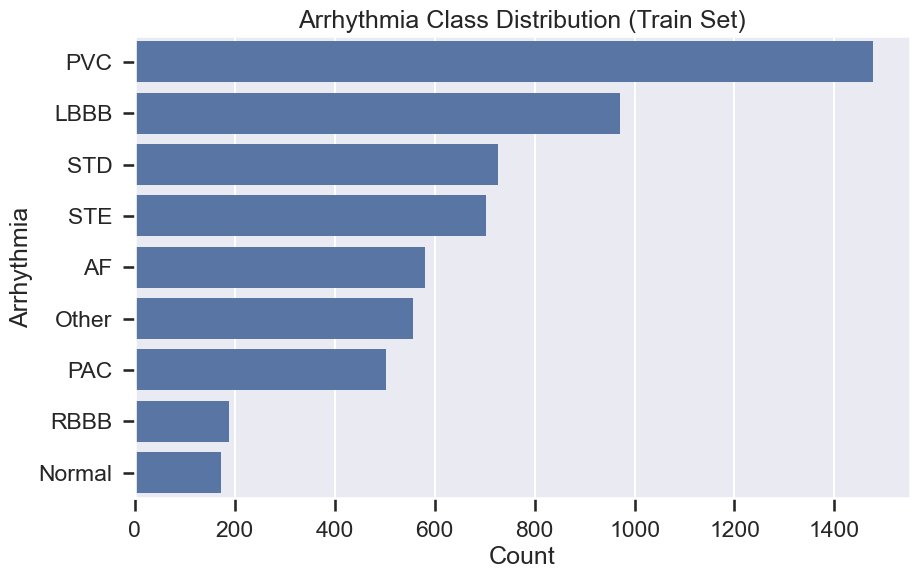

,Arrhythmia,Count
4,PVC,1477
1,LBBB,971
5,STD,726
6,STE,702
0,AF,581
8,Other,557
3,PAC,503
2,RBBB,189
7,Normal,172


In [13]:
label_names = [
    "AF", "LBBB", "RBBB", "PAC", "PVC",
    "STD", "STE", "Normal", "Other"
]

label_counts = y.sum(axis=0)

df_labels = pd.DataFrame({
    "Arrhythmia": label_names,
    "Count": label_counts
}).sort_values("Count", ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=df_labels, x="Count", y="Arrhythmia")
plt.title("Arrhythmia Class Distribution (Train Set)")
plt.show()

df_labels

## Step 10: Variable-Length Signal and Duration Analysis

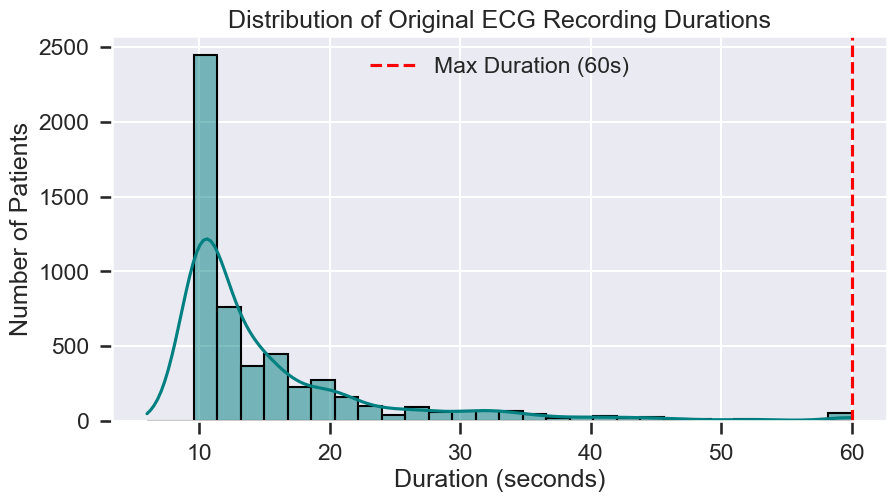

In [18]:
# Calculate effective duration (ignoring zero-padding)
original_durations = []
fs = 250

for signal in X:
    # signal shape is (12, 15000)
    # np.where returns (lead_indices, time_indices)
    # We want time_indices, which is at index 1
    non_zero_indices = np.where(np.abs(signal) > 0)[1] 
    
    if len(non_zero_indices) > 0:
        # Calculate duration from first non-zero point to last non-zero point
        duration_samples = non_zero_indices.max() - non_zero_indices.min()
        original_durations.append(duration_samples / fs)
    else:
        original_durations.append(0)

# Plot Distribution
plt.figure(figsize=(10, 5))
sns.histplot(original_durations, bins=30, kde=True, color='teal')
plt.title("Distribution of Original ECG Recording Durations")
plt.xlabel("Duration (seconds)")
plt.ylabel("Number of Patients")
plt.axvline(x=60, color='red', linestyle='--', label='Max Duration (60s)')
plt.legend()
plt.show()

## Step 11: Multi-Label Cardinality

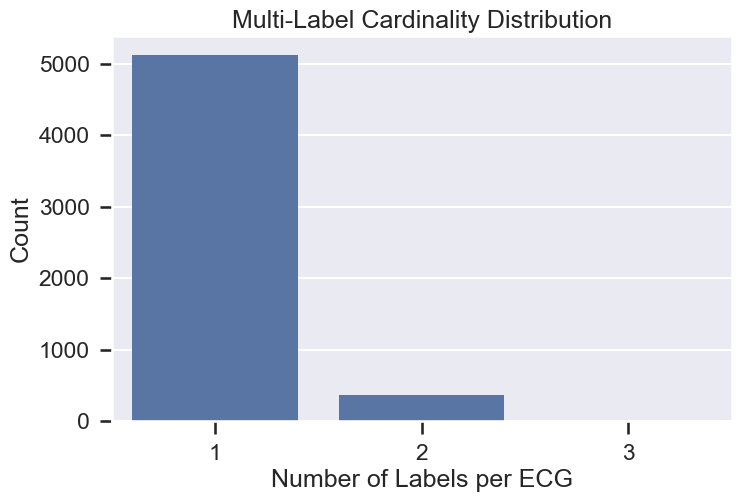

Multi-label ECG percentage: 6.74%


In [14]:
label_cardinality = y.sum(axis=1)

plt.figure(figsize=(8, 5))
sns.countplot(x=label_cardinality)
plt.xlabel("Number of Labels per ECG")
plt.ylabel("Count")
plt.title("Multi-Label Cardinality Distribution")
plt.show()

print(f"Multi-label ECG percentage: {(label_cardinality > 1).mean() * 100:.2f}%")

## Step 12: Lead-wise Correlation Matrix

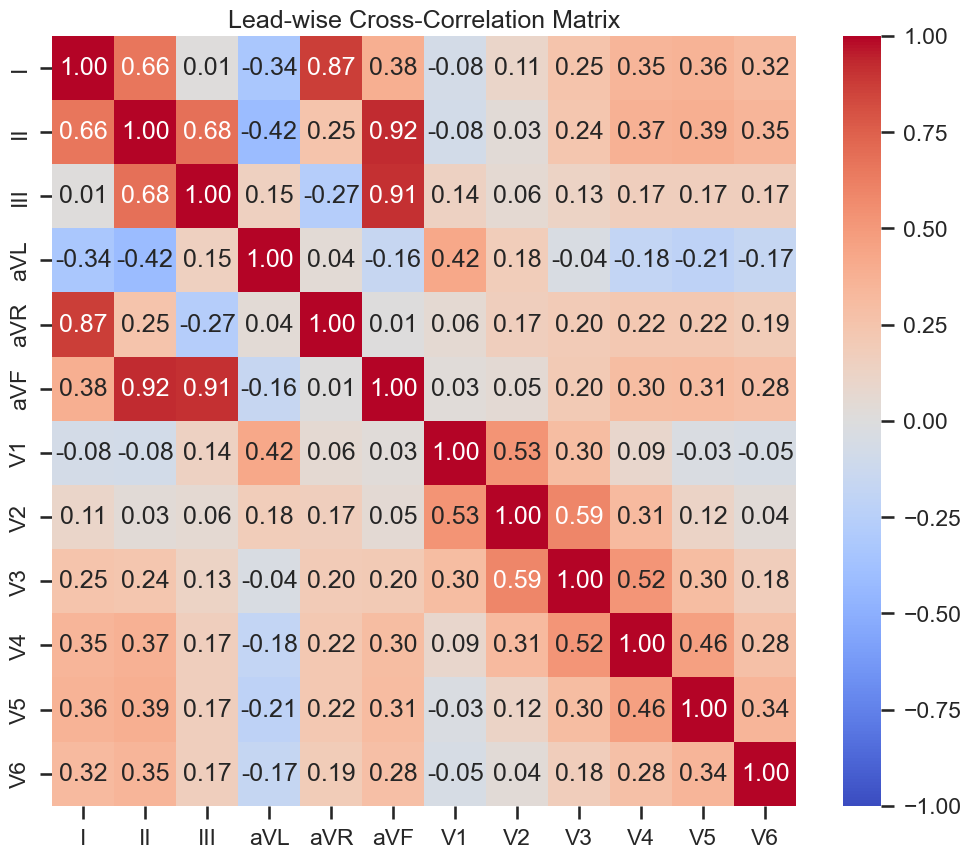

In [19]:
# Compute correlation between leads across the entire dataset
# X shape is (N, 12, 15000) -> (5501, 12, 15000)

# 1. Transpose to bring Leads to the front: (12, N, 15000)
X_leads_first = np.transpose(X, (1, 0, 2))

# 2. Flatten the other dimensions: (12, N * 15000)
# This creates one long vector for each lead containing every sample from every patient
X_reshaped = X_leads_first.reshape(12, -1) 

# 3. Compute Pearson Correlation
correlation_matrix = np.corrcoef(X_reshaped)

# 4. Plot
lead_names = ["I", "II", "III", "aVL", "aVR", "aVF",
              "V1", "V2", "V3", "V4", "V5", "V6"]

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, 
            annot=True, 
            fmt=".2f", 
            xticklabels=lead_names, 
            yticklabels=lead_names,
            cmap="coolwarm", 
            vmin=-1, vmax=1)
plt.title("Lead-wise Cross-Correlation Matrix")
plt.show()

## Step 13: Lead-wise Morphology Analysis (Statistical)

In [16]:
lead_stats = []

for i, lead in enumerate(lead_names):
    lead_stats.append({
        "Lead": lead,
        "Mean": X[:, i, :].mean(),
        "Std":  X[:, i, :].std(),
        "Min":  X[:, i, :].min(),
        "Max":  X[:, i, :].max()
    })

pd.DataFrame(lead_stats)

,Lead,Mean,Std,Min,Max
0,I,0.021069,94.119754,-17996.5,21632.5
1,II,0.021109,105.432387,-12060.5,20071.0
2,III,0.022438,96.103932,-12160.5,19907.5
3,aVL,0.019007,90.954306,-13342.5,20102.5
4,aVR,0.020827,82.948446,-15670.0,21046.0
5,aVF,0.021169,92.428677,-12110.5,19989.5
6,V1,0.031930,159.012239,-14179.5,21376.0
7,V2,0.023206,205.598651,-13392.0,21508.0
8,V3,0.015855,215.955976,-14158.5,22084.5
9,V4,0.005761,238.069388,-14038.0,22371.0


 ## Step 14: Multi-label Co-occurrence Pattern Analysis

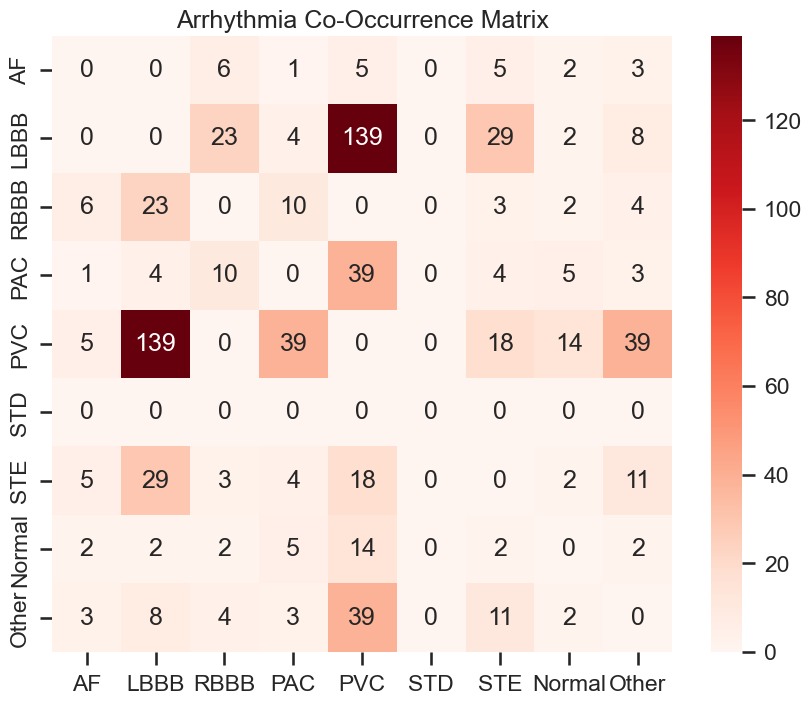

In [21]:
co_occurrence = np.zeros((9, 9))

for labels in y:
    active = np.where(labels == 1)[0]
    for i, j in combinations(active, 2):
        co_occurrence[i, j] += 1
        co_occurrence[j, i] += 1

label_names = [
    "AF", "LBBB", "RBBB", "PAC", "PVC",
    "STD", "STE", "Normal", "Other"
]

co_df = pd.DataFrame(
    co_occurrence,
    index=label_names,
    columns=label_names
)

plt.figure(figsize=(10, 8))
sns.heatmap(co_df, annot=True, fmt=".0f", cmap="Reds")
plt.title("Arrhythmia Co-Occurrence Matrix")
plt.show()